In [70]:
import pandas as pd
import numpy as np


# Load data
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('dev.csv')
test_df = pd.read_csv('test.csv')

In [71]:
test_df.head(5)

,text,label
0,missed brent praise band fun lead guitarist lt...,0
1,tanialt beth tastic widgetsworld spcialndsjung...,1
2,m m feel like ending just want girlfriend reje...,1
3,late night snack glass oj b c m quot sickness ...,0
4,ensconced thought diametrically opposed gradua...,1


### Train

In [72]:
# pip install transformers datasets

In [73]:
from datasets import Dataset, DatasetDict
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import torch
from transformers import get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import os

In [74]:
os.environ["TRANSFORMERS_VERBOSITY"] = "error"
os.environ["WANDB_DISABLED"] = "true"

### cardiffnlp/twitter-roberta-base-sentiment
https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment?text=I+like+you.+I+love+you



In [75]:
# Convert DataFrame to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Merge datasets
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

In [76]:
# Tokenizer
model_checkpoint = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = RobertaTokenizer.from_pretrained(model_checkpoint)

# Tokenize
def preprocess_function(examples):
    cleaned_texts = [str(text) if text else "" for text in examples["text"]]
    return tokenizer(cleaned_texts, truncation=True, max_length=128)

tokenized_datasets = dataset.map(preprocess_function, batched=True)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /cardiffnlp/twitter-roberta-base-sentiment/resolve/main/vocab.json HTTP/1.1" 200 0
loading file vocab.json from cache at /Users/qiguo/.cache/huggingface/hub/models--cardiffnlp--twitter-roberta-base-sentiment/snapshots/daefdd1f6ae931839bce4d0f3db0a1a4265cd50f/vocab.json
loading file merges.txt from cache at /Users/qiguo/.cache/huggingface/hub/models--cardiffnlp--twitter-roberta-base-sentiment/snapshots/daefdd1f6ae931839bce4d0f3db0a1a4265cd50f/merges.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /Users/qiguo/.cache/huggingface/hub/models--cardiffnlp--twitter-roberta-base-sentiment/snapshots/daefdd1f6ae931839bce4d0f3db0a1a4265cd50f/special_tokens_map.json
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /Users/qiguo/.cache/huggingf

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [77]:
# Load the model
model = RobertaForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2, ignore_mismatched_sizes=True)  # 2 classes

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /cardiffnlp/twitter-roberta-base-sentiment/resolve/main/config.json HTTP/1.1" 200 0
loading configuration file config.json from cache at /Users/qiguo/.cache/huggingface/hub/models--cardiffnlp--twitter-roberta-base-sentiment/snapshots/daefdd1f6ae931839bce4d0f3db0a1a4265cd50f/config.json
Model config RobertaConfig {
  "_name_or_path": "tweeteval_new/roberta-base-rt-sentiment/",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_

In [78]:
# Data Collector
data_collator = DataCollatorWithPadding(tokenizer)

In [79]:
# Evaluation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = torch.argmax(torch.tensor(predictions), dim=-1)
    accuracy = (preds == torch.tensor(labels)).float().mean().item()
    return {"accuracy": accuracy}

In [80]:
# parameters
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [81]:
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

In [82]:
# learning rate scheduler
num_training_steps = len(tokenized_datasets["train"]) // training_args.per_device_train_batch_size * training_args.num_train_epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=num_training_steps)

In [83]:
# Trainer class
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_metrics,
)

# Train
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 6184
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1935


Epoch,Training Loss,Validation Loss,Accuracy
1,0.179600,0.121862,0.963777
2,0.064800,0.128373,0.974127
3,0.024000,0.125911,0.976714
4,0.000100,0.144965,0.975420
5,0.000100,0.142296,0.974127


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 773
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 773
  Batch size = 1

TrainOutput(global_step=1935, training_loss=0.05066942368262238, metrics={'train_runtime': 3576.6611, 'train_samples_per_second': 8.645, 'train_steps_per_second': 0.541, 'total_flos': 1841991165252480.0, 'train_loss': 0.05066942368262238, 'epoch': 5.0})

In [84]:
# Evaluate
print("Validation metrics:")
trainer.evaluate(eval_dataset=tokenized_datasets["validation"])

print("Test metrics:")
trainer.evaluate(eval_dataset=tokenized_datasets["test"])

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 773
  Batch size = 16


Validation metrics:


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 774
  Batch size = 16


Test metrics:


{'eval_loss': 0.1634438931941986,
 'eval_accuracy': 0.9741601943969727,
 'eval_runtime': 24.3621,
 'eval_samples_per_second': 31.771,
 'eval_steps_per_second': 2.011,
 'epoch': 5.0}

In [85]:
# Save
model.save_pretrained('./trained_model')
tokenizer.save_pretrained('./trained_model')

Configuration saved in ./trained_model/config.json
Model weights saved in ./trained_model/pytorch_model.bin
tokenizer config file saved in ./trained_model/tokenizer_config.json
Special tokens file saved in ./trained_model/special_tokens_map.json


('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 './trained_model/vocab.json',
 './trained_model/merges.txt',
 './trained_model/added_tokens.json')

In [ ]:
# # Load
# model = RobertaForSequenceClassification.from_pretrained('./trained_model')
# tokenizer = RobertaTokenizer.from_pretrained('./trained_model')

In [86]:
# Get predictions for the test set using the trained model
def get_predictions_and_logits(trainer, dataset):
    predictions, labels, metrics = trainer.predict(dataset)
    
    # Convert logits to predicted labels (0 or 1)
    predicted_labels = np.argmax(predictions, axis=-1)

    return predictions, predicted_labels, labels

In [87]:
# Get predictions, logits, and true labels for the test dataset
predictions, predicted_labels, true_labels = get_predictions_and_logits(trainer, tokenized_datasets["test"])

# Convert logits to pandas DataFrame for easy manipulation
logits_df = pd.DataFrame(predictions, columns=["logit_" + str(i) for i in range(predictions.shape[1])])

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 774
  Batch size = 16


In [88]:
# Create a DataFrame with text, true labels, and predicted labels
results_df = pd.DataFrame({
    'text': tokenized_datasets["test"]["text"],
    'label': true_labels,
    'label_pred': predicted_labels
})

# Concatenate logits DataFrame with the results_df
final_df = pd.concat([results_df, logits_df], axis=1)
final_df.to_csv("test_predictions_with_logits_Train.csv", index=False)

print("Results saved")

Results saved


In [90]:
# Filter out misclassified samples
misclassified_df = results_df[results_df['label'] != results_df['label_pred']]
misclassified_df.to_csv('misclassified_samples_Train.csv', index=False)

In [91]:
# Count per label
misclassified_counts = misclassified_df['label'].value_counts()

# Display distribution
print(f"Misclassification distribution:\n{misclassified_counts}")

Misclassification distribution:
label
0    10
1    10
Name: count, dtype: int64


In [92]:
misclassified_df

,text,label,label_pred
36,stress culminates physical pain,0,1
64,smoked time month m freaking idk edit m good b...,1,0
72,fuck la circulation ce mat,0,1
77,profile want read,1,0
80,stupid arranged marriage ll convert marry love,0,1
90,confused don t know whats real m dramatic actu...,1,0
109,hate life today s s post,1,0
205,body reply,0,1
207,just did km tready want die m built running,0,1
262,penalba por favor decime ke estas involucrado ...,0,1


### nlptown/bert-base-multilingual-uncased-sentiment
https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment?text=i+am+so+sad

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification

In [6]:
# Convert DataFrame to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# datasets
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

os.environ["WANDB_DISABLED"] = "true"

# Load Tokenizer for BERT
model_checkpoint = "nlptown/bert-base-multilingual-uncased-sentiment"  
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)  # Changed to BertTokenizer

# Tokenize
def preprocess_function(examples):
    cleaned_texts = [str(text) if text else "" for text in examples["text"]]
    return tokenizer(cleaned_texts, truncation=True, max_length=128)

tokenized_datasets = dataset.map(preprocess_function, batched=True)

model = BertForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2, ignore_mismatched_sizes=True)  

data_collator = DataCollatorWithPadding(tokenizer)

# Evaluation function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = torch.argmax(torch.tensor(predictions), dim=-1)  
    accuracy = (preds == torch.tensor(labels)).float().mean().item()  
    return {"accuracy": accuracy}

# Training parameters
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  
    learning_rate=2e-5,  
    per_device_train_batch_size=16, 
    per_device_eval_batch_size=16,  
    num_train_epochs=5, 
    weight_decay=0.01,  
    logging_dir='./logs',  
    logging_steps=10,  
)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

# Learning rate scheduler
num_training_steps = len(tokenized_datasets["train"]) // training_args.per_device_train_batch_size * training_args.num_train_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0, 
                                            num_training_steps=num_training_steps)

# Trainer class
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate on the validation dataset
print("Validation metrics:")
trainer.evaluate(eval_dataset=tokenized_datasets["validation"])

# Evaluate on the test dataset
print("Test metrics:")
trainer.evaluate(eval_dataset=tokenized_datasets["test"])

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

loading file vocab.txt from cache at /Users/qiguo/.cache/huggingface/hub/models--nlptown--bert-base-multilingual-uncased-sentiment/snapshots/edd66abe7147abbc7c23e0c339a5f617918d8060/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /Users/qiguo/.cache/huggingface/hub/models--nlptown--bert-base-multilingual-uncased-sentiment/snapshots/edd66abe7147abbc7c23e0c339a5f617918d8060/special_tokens_map.json
loading file tokenizer_config.json from cache at /Users/qiguo/.cache/huggingface/hub/models--nlptown--bert-base-multilingual-uncased-sentiment/snapshots/edd66abe7147abbc7c23e0c339a5f617918d8060/tokenizer_config.json


Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

loading configuration file config.json from cache at /Users/qiguo/.cache/huggingface/hub/models--nlptown--bert-base-multilingual-uncased-sentiment/snapshots/edd66abe7147abbc7c23e0c339a5f617918d8060/config.json
Model config BertConfig {
  "_name_or_path": "nlptown/bert-base-multilingual-uncased-sentiment",
  "_num_labels": 5,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "finetuning_task": "sentiment-analysis",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "1 star",
    "1": "2 stars",
    "2": "3 stars",
    "3": "4 stars",
    "4": "5 stars"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "1 star": 0,
    "2 stars": 1,
    "3 stars": 2,
    "4 stars": 3,
    "5 stars": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads":

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

loading configuration file config.json from cache at /Users/qiguo/.cache/huggingface/hub/models--nlptown--bert-base-multilingual-uncased-sentiment/snapshots/edd66abe7147abbc7c23e0c339a5f617918d8060/config.json
Model config BertConfig {
  "_num_labels": 5,
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "finetuning_task": "sentiment-analysis",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_ver

Downloading:   0%|          | 0.00/669M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /Users/qiguo/.cache/huggingface/hub/models--nlptown--bert-base-multilingual-uncased-sentiment/snapshots/edd66abe7147abbc7c23e0c339a5f617918d8060/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none)

Epoch,Training Loss,Validation Loss,Accuracy
1,0.206400,0.144901,0.953428
2,0.037300,0.110792,0.971539
3,0.044000,0.153201,0.970246
4,0.000200,0.185412,0.968952
5,0.015800,0.189895,0.971539


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 773
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 773
  Batch size = 16
Saving mod

Validation metrics:


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 774
  Batch size = 16


Test metrics:


{'eval_loss': 0.1882229596376419,
 'eval_accuracy': 0.9728682041168213,
 'eval_runtime': 24.7361,
 'eval_samples_per_second': 31.29,
 'eval_steps_per_second': 1.981,
 'epoch': 5.0}

### Test evaluation without training

In [37]:
import os

# Disable tokenizers parallelism
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"

# Clear the Hugging Face cache
# !rm -rf ~/.cache/huggingface/transformers/

In [38]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import pandas as pd
from datasets import Dataset
from sklearn.metrics import accuracy_score

# Load pre-trained tokenizer and model from Hugging Face
model_checkpoint = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = RobertaTokenizer.from_pretrained(model_checkpoint)
model = RobertaForSequenceClassification.from_pretrained(model_checkpoint)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /cardiffnlp/twitter-roberta-base-sentiment/resolve/main/vocab.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /cardiffnlp/twitter-roberta-base-sentiment/resolve/main/config.json HTTP/1.1" 200 0


In [41]:
# Convert Pandas DataFrame to Hugging Face Dataset
test_dataset = Dataset.from_pandas(test_df)

# Preprocess function for tokenizing text
def preprocess_function(examples):
    cleaned_texts = [str(text) if text else "" for text in examples["text"]]
    return tokenizer(cleaned_texts, truncation=True, padding=True, max_length=128)

# Tokenize the dataset
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [42]:
# Set model to evaluation mode
model.eval()

# Get the logits (raw output) from the model
def get_predictions(tokenized_dataset):
    predictions = []
    with torch.no_grad():
        for batch in tokenized_dataset:
            inputs = {key: torch.tensor(val).unsqueeze(0) for key, val in batch.items() if key in tokenizer.model_input_names}
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_class = torch.argmax(logits, dim=-1).item()
            predictions.append(predicted_class)
    return predictions

predictions = get_predictions(tokenized_test_dataset)

In [43]:
# Map 3-class predictions to 2-class labels
def map_to_binary(predictions):
    binary_predictions = []
    for pred in predictions:
        if pred == 0:  # negative -> depressed
            binary_predictions.append(1)
        else:  # neutral/positive -> health
            binary_predictions.append(0)
    return binary_predictions

binary_predictions = map_to_binary(predictions)

In [44]:
# True labels
true_labels = test_df['label'].tolist()

# Compute accuracy
accuracy = accuracy_score(true_labels, binary_predictions)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6072


#### Output logits vector

In [45]:
# Get the logits (raw output) from the model along with the text and label
def get_predictions_with_logits(tokenized_dataset):
    texts = []
    labels = []
    logits_list = []
    with torch.no_grad():
        for i, batch in enumerate(tokenized_dataset):
            # Prepare inputs
            inputs = {key: torch.tensor(val).unsqueeze(0) for key, val in batch.items() if key in tokenizer.model_input_names}
            
            # Get model outputs (logits)
            outputs = model(**inputs)
            logits = outputs.logits.detach().cpu().numpy().flatten() 
            
            # Store text, label, and logits
            texts.append(test_df["text"].iloc[i])
            labels.append(test_df["label"].iloc[i])
            logits_list.append(logits)
    
    return texts, labels, logits_list

# Get predictions and logits for the test dataset
texts, labels, logits_list = get_predictions_with_logits(tokenized_test_dataset)

# Create a DataFrame to store text, label, and logits
results_df = pd.DataFrame({
    'text': texts,
    'label': labels,
    'logits': logits_list
})


results_df.to_csv('test_results_with_logits.csv', index=False)
print("Results saved")

Results saved to 'test_results_with_logits.csv'


In [46]:
# Get the logits from the model along with the text and label
def get_predictions_with_logits(tokenized_dataset):
    texts = []
    labels = []
    logits_list = []
    label_preds = [] 
    with torch.no_grad():
        for i, batch in enumerate(tokenized_dataset):
            inputs = {key: torch.tensor(val).unsqueeze(0) for key, val in batch.items() if key in tokenizer.model_input_names}
            
            outputs = model(**inputs)
            logits = outputs.logits.detach().cpu().numpy().flatten() 
            
            # Get the predicted label (index of max logit value)
            predicted_label = logits.argmax() 
            
            # Map 3-class predictions to 2-class labels (depressed = 1, health = 0)
            label_pred = map_to_binary([predicted_label])[0]
            
            # Store text, label, logits, and predicted label
            texts.append(test_df["text"].iloc[i])
            labels.append(test_df["label"].iloc[i])
            logits_list.append(logits) 
            label_preds.append(label_pred)
    
    return texts, labels, logits_list, label_preds

# Get predictions, logits, and predicted labels for the test dataset
texts, labels, logits_list, label_preds = get_predictions_with_logits(tokenized_test_dataset)

results_df = pd.DataFrame({
    'text': texts,
    'label': labels,
    'logits': logits_list,  
    'label_pred': label_preds  
})

results_df.to_csv('test_results_with_logits_and_predictions.csv', index=False)
print("Results saved")

Results saved


#### Misclassified

In [54]:
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("datasets").setLevel(logging.ERROR)

In [58]:
# Filter out misclassified samples
misclassified_df = results_df[results_df['label'] != results_df['label_pred']]

In [48]:
misclassified_df.to_csv('misclassified_samples_nonTrain.csv', index=False)

In [49]:
# Count per label
misclassified_counts = misclassified_df['label'].value_counts()

# Display distribution
print(f"Misclassification distribution:\n{misclassified_counts}")

Misclassification distribution:
label
0    179
1    125
Name: count, dtype: int64


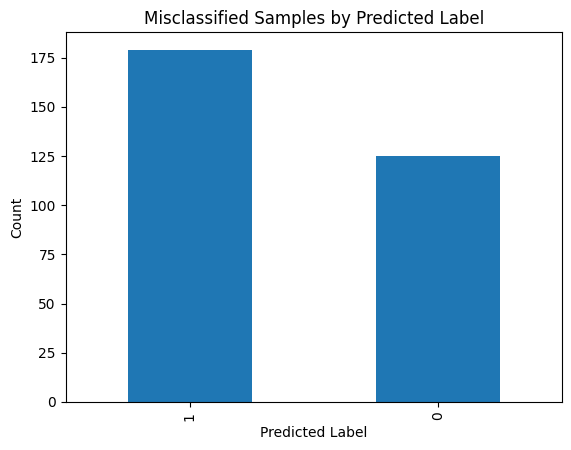

In [55]:
import matplotlib.pyplot as plt

misclassified_df['label_pred'].value_counts().plot(kind='bar', title="Misclassified Samples by Predicted Label")
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.show()

In [50]:
misclassified_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304 entries, 3 to 773
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        303 non-null    object
 1   label       304 non-null    int64 
 2   logits      304 non-null    object
 3   label_pred  304 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.9+ KB


In [60]:
misclassified_df.head(10)

,text,label,logits,label_pred
3,late night snack glass oj b c m quot sickness ...,0,"[3.0297499, -0.51466477, -2.6291506]",1
4,ensconced thought diametrically opposed gradua...,1,"[-1.0581923, 1.1503406, -0.1986687]",0
14,ve tinnitus like year related anxiety neck pai...,1,"[0.28424332, 0.87818867, -1.2747302]",0
18,amidst conflict ukraine russia contention test...,1,"[0.6774169, 1.3289019, -2.1771953]",0
21,nearly dollar saved student working hour week ...,1,"[-1.4303167, 0.43625298, 1.0886158]",0
23,really cold,0,"[1.0366995, 0.5091419, -1.427758]",1
26,fucking boredom make wan na smoke,0,"[2.2685206, -0.13657193, -2.0035968]",1
27,riry pain nomming hand sprayed cat nip mist jo...,0,"[1.1416659, 0.70770323, -1.8363186]",1
28,talking bout depression girl just got pill,1,"[0.81741226, 1.0070555, -1.911675]",0
33,thanks chaffie thousand apology fogive sinned,0,"[0.7478117, 0.4113267, -1.1696522]",1
